In [333]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd


def distmat(x, y):
    return np.sum(x**2, 0)[:, None] + np.sum(y**2, 0)[None, :] - 2*x.transpose().dot(y)


def normalize(a):
    return a/np.sum(a)


def add_intercept(dfX):
    dfX['intercept'] = 1
    l_col = list(dfX.columns)
    l_col.remove('intercept')
    return dfX[['intercept']+l_col]


class VectorQuantileRegression:

    def __init__(self):

        self.X = None
        self.Y = None
        self.U = None
        self.d = None
        self.m = None
        self.n = None
        self.q = None
        self.step = None
        self.df = None

    def get_U(self, d, step):

        if d > 6:
            print("Only d<=6 is yet supported")
            return None

        elif d == 1:
            u = np.arange(0, 1+step, step).T

        elif d == 2:
            x = np.arange(0, 1+step, step)
            x, y = np.meshgrid(x, x)
            u = np.array([x.flatten(), y.flatten()]).T

        elif d == 3:
            x = np.arange(0, 1+step, step)
            x, y, z = np.meshgrid(x, x, x)
            u = np.array([x.flatten(), y.flatten(), z.flatten()]).T

        elif d == 4:
            x = np.arange(0, 1+step, step)
            x, y, z, x1 = np.meshgrid(x, x, x, x)
            u = np.array([x.flatten(), y.flatten(),
                          z.flatten(), x1.flatten()]).T

        elif d == 5:
            x = np.arange(0, 1+step, step)
            x, y, z, x1, y1 = np.meshgrid(x, x, x, x, x)
            u = np.array([x.flatten(), y.flatten(),
                          z.flatten(), x1.flatten(), y1.flatten()]).T

        elif d == 6:
            x = np.arange(0, 1+step, step)
            x, y, z, x1, y1, z1 = np.meshgrid(x, x, x, x, x, x)
            u = np.array([x.flatten(), y.flatten(), z.flatten(), x1.flatten(),
                          y1.flatten(), z1.flatten()]).T
        return u

    def fit(self, X, Y, step=0.05, verbose=False):
        Y = Y.to_numpy().T
        X = add_intercept(X).to_numpy()
        self.X = X
        self.Y = Y

        self.q = X.shape[1]

        d = Y.shape[0]
        self.d = d
        self.step = step

        u = self.get_U(d, step)
        U = u.T
        self.U = U

        n = Y.shape[1]
        m = U.shape[1]

        self.n = n
        self.m = m

        nu = normalize(np.random.rand(n, 1))
        mu = normalize(np.random.rand(m, 1))

        C = distmat(U, Y)
        P = cp.Variable((m, n))
        ind_m = np.ones((m, 1))
        constraints = [0 <= P,
                       cp.matmul(P.T, ind_m) == nu,
                       cp.matmul(P, X) == cp.matmul(cp.matmul(mu, nu.T), X)]

        objective = cp.Minimize(cp.sum(cp.multiply(P, C)))
        prob = cp.Problem(objective, constraints)
        result = prob.solve(verbose=verbose)
        psi = constraints[1].dual_value
        b = constraints[2].dual_value

        self.result = result
        self.b = b
        self.psi = psi

    def get_dfU(self, U, b, step):
        u = U.T
        d = u.shape[1]
        dfU = pd.DataFrame(u)
        dim = [i for i in range(d)]
        self.dim = dim
        dfU[[str(i)+"_follower" for i in list(dfU.columns)]] = dfU[dfU.columns]

        for k in range(d):

            dfU_temp = dfU.copy()
            dfU_temp[k] = dfU_temp[k].apply(
                                        lambda x: x+step if x < 1 else x-step)

            find_in = list(dfU[dim].apply(
                                    lambda x: list(np.around(x, 3)), axis=1))
            dfU[str(k)+"_follower"] = dfU_temp[dim].apply(
                        lambda x: list(np.around(x, 3)), axis=1
                                                            ).apply(
                                                    lambda x: find_in.index(x)
                                                                    )

        dfU['b'] = pd.DataFrame(b).apply(np.array, axis=1)

        for i in range(d):
            dfU['beta_'+str(i)] = (dfU.loc[list(dfU[str(i)+"_follower"])][['b']].reset_index(drop=True) - dfU[['b']])/step

        beta = ['beta_'+str(i) for i in range(2)]
        dfU['beta'] = dfU[beta].apply(lambda x: np.vstack(x), axis=1)

        return dfU

    def predict(self, X=None, u_quantile=None, argument="U"):

        '''
        argument in {"U", "X"}
        u_quantile liste with quantiles
        '''
        U = self.U
        b = self.b
        step = self.step
        X = add_intercept(X)

        if argument == "X":

            if self.df is None:
                df = self.get_dfU(U, b, step)
                self.df = df
            else:
                df = self.df

            ser = pd.Series([u_quantile]*m)

            pos = df[self.dim].apply(lambda x: list(np.around(x, 3)), axis=1)
            beta = df['beta'][pos == ser].iloc[0]

            xeval = X.apply(lambda x: np.array(x).reshape(-1,1), axis=1).to_frame()
            xeval.columns = ['X']
            df_res = xeval.copy()

            if self.q == 1:
                df_res['y_pred'] = df_res['X'].apply(lambda x: beta*x)
            else:
                df_res['y_pred'] = df_res['X'].apply(lambda x: np.matmul(beta,x))

            return df_res

        elif argument == "U":
            if xeval.shape != (self.q,):
                print("If argument = U then you can only give one observation.")
                return

            if self.df is None:
                df = self.get_dfU(U, b, step)
                self.df = df
            else:
                df = self.df

            df['y_pred'] = df['beta'].apply(lambda x: np.matmul(x, X))

            return df[self.dim + ['y_pred']]

        else:
            print("argument not recognized")
            return None

#    def plot_surface():
#        "une fonction pour ploter les surfaces"

#    def plot_lines():


In [334]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [335]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import cv2
import random

In [336]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [338]:
X = pd.read_excel('Data/MVEngel.xls', 'X' ,header= None)
Y = pd.read_excel('Data/MVEngel.xls', 'Y' ,header= None).fillna(0)

X.columns = ['income']

Y.columns = ['food',
'clothing',
'housing',
'heating/lightening',
'tools',
'education',
'public safety',
'health',
'services'
]

In [340]:
X

,income
0,835.94
1,873.44
2,951.44
3,473.00
4,601.00
...,...
230,718.36
231,543.90
232,1587.35
233,4957.83


In [341]:
Y = Y[['food',
'clothing']]

In [342]:
Y.to_numpy().T.shape

(2, 235)

In [343]:
clf = VectorQuantileRegression()

In [344]:
clf.fit(X,Y)

In [345]:
x_test = pd.DataFrame(np.arange(600,1400,100))

In [346]:
dr = clf.predict(X= x_test, u_quantile=[0.8,0.8], argument ="X")

In [347]:
dr['y_pred']#.iloc[0].shape

0     [[882.7622804460407], [152.28321469318416]]
1    [[1011.6679480811217], [194.20207663115661]]
2    [[1140.5736157162028], [236.12093856912907]]
3     [[1269.4792833512838], [278.0398005071015]]
4    [[1398.3849509863649], [319.95866244507397]]
5      [[1527.290618621446], [361.8775243830464]]
6      [[1656.196286256527], [403.7963863210189]]
7      [[1785.101953891608], [445.7152482589913]]
Name: y_pred, dtype: object

In [ ]:
beta.shape

In [114]:
import pandas as pd

X = pd.read_csv('Data/MVEngelX.csv', header= None)
Y = pd.read_csv('Data/MVEngelY.csv', header= None)

X.columns = ['X']
Y.columns = ['Y1', 'Y2']

df = Y
df['Intercept'] =1
df['X'] = X
#df['X2'] = X**2

df.head(5)

,Y1,Y2,Intercept,X
0,576.28,125.12,1,835.94
1,631.80,153.64,1,873.44
2,608.64,186.00,1,951.44
3,301.00,122.00,1,473.00
4,378.00,134.00,1,601.00


In [124]:
np.matmul(beta,df['X'].loc[0])

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [129]:
np.array([df['X'].loc[0]]).shape

(1,)

In [130]:
df['X'].apply(lambda x: np.matmul(beta,np.array([x])))

0       [663.3565138986073, 200.45692442073124]
1       [693.1144741244582, 209.44935768840287]
2        [755.011031394228, 228.15361888515986]
3      [375.34707164873225, 113.42455828289815]
4       [476.92090921963654, 144.1187305032173]
                         ...                   
230     [570.0514215424594, 172.26144965772244]
231     [431.60945511574096, 130.4262521143093]
232    [1259.6346177201165, 380.64370526502825]
233     [3934.2642119074717, 1188.878811398945]
234     [769.4932387041421, 232.52993640876005]
Name: X, Length: 235, dtype: object

In [13]:
X = df[['Intercept'
        , 'X'
      #  , 'X2'
       ]].to_numpy()

Y = df[[
        'Y1',
        'Y2'
        ]].to_numpy()

d = Y.shape[1]

In [14]:
Y.shape

(235, 2)

In [15]:
def get_U(d, step):
    
    if d > 6 :
        print("Only d<=6 is yet supported")
        return None
    
    elif d == 1 :
        u=np.arange(0, 1+step, step).T
    
    elif d ==2 :
        x = np.arange(0, 1+step, step)
        x,y = np.meshgrid(x,x)
        u=np.array([x.flatten(),y.flatten()]).T

    elif d ==3 :
        x = np.arange(0, 1+step, step)
        x,y,z = np.meshgrid(x,x,x)
        u=np.array([x.flatten(),y.flatten(), z.flatten()]).T

    elif d ==4 :
        x = np.arange(0, 1+step, step)
        x,y,z,x1 = np.meshgrid(x,x,x,x)
        u=np.array([x.flatten(),y.flatten(), z.flatten(),x1.flatten()]).T

    elif d == 5 :
        x = np.arange(0, 1+step, step)
        x,y,z,x1, y1 = np.meshgrid(x,x,x,x,x)
        u=np.array([x.flatten(),y.flatten(), z.flatten(), x1.flatten(), y1.flatten()]).T

    elif d == 6 :
        x = np.arange(0, 1+step, step)
        x,y,z,x1, y1, z1 = np.meshgrid(x,x,x,x,x,x)
        u=np.array([x.flatten(),y.flatten(), z.flatten(), x1.flatten(), y1.flatten(), z1.flatten()]).T
    
    return u

In [16]:
step = 0.05
u = get_U(2, step)

In [17]:
U = u.T
Y = Y.T

In [18]:
U.shape , Y.shape, X.shape

((2, 441), (2, 235), (235, 2))

In [19]:
n = Y.shape[1]
m = U.shape[1]


In [20]:
normalize = lambda a: a/np.sum(a)
nu = normalize(np.random.rand(n, 1))
mu = normalize(np.random.rand(m, 1))

In [21]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(U,Y)

In [22]:
P = cp.Variable((m,n))
ind_n = np.ones((n,1))
ind_m = np.ones((m,1))

In [23]:
constraints = [0 <= P, cp.matmul(P.T,ind_m)==nu, cp.matmul(P,X)==cp.matmul(cp.matmul(mu,nu.T),X)]

In [24]:
%%time
objective = cp.Minimize(cp.sum(cp.multiply(P,C)))
prob = cp.Problem(objective, constraints)
result = prob.solve()

Wall time: 1.31 s


In [25]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 4535 (n + m-1 = 675)


In [26]:
psi = constraints[1].dual_value
b = constraints[2].dual_value

# Precious function

In [27]:
U.shape

(2, 441)

In [28]:
def get_dfU(U, b,step):
    d = U.T.shape[1]
    dfU = pd.DataFrame(u)
    dim = [i for i in range(d)]
    dfU[[str(i)+"_follower" for i in list(dfU.columns)]] = dfU[dfU.columns]

    for k in range(d):
    
        dfU_temp = dfU.copy()
        dfU_temp[k] = dfU_temp[k].apply(lambda x: x+step if x<1 else x-step )
    
        find_in = list(dfU[dim].apply(lambda x: list(np.around(x, 3)),axis=1))
    
        dfU[str(k)+"_follower"] = dfU_temp[dim].apply(lambda x: list(np.around(x, 3)), axis =1).apply(lambda x: find_in.index(x))
    
    dfU['b']=pd.DataFrame(b).apply(np.array,axis=1)
    
    for i in range(d):
        dfU['beta_'+str(i)]=(dfU.loc[list(dfU[str(i)+"_follower"])][['b']].reset_index(drop=True) - dfU[['b']])/step
    
    beta = ['beta_'+str(i) for i in range(2)]
    dfU['beta'] = dfU[beta].apply(lambda x : np.vstack(x), axis = 1)
    
    return dfU

In [29]:
xeval = np.array([1,
                  883.99,
                  #883.99**2
                 ])
xeval.shape

(2,)

In [36]:
xeval.shape ==(d,)

True

In [30]:
df = get_dfU(U, b,step)

In [31]:
y_hat = df['beta'].apply(lambda x : np.matmul(x, xeval))

In [151]:
y_1_hat = y_hat.apply(lambda x: x[0])
y_2_hat = y_hat.apply(lambda x: x[1])

In [152]:
y_1_hat = np.abs(y_1_hat)
y_2_hat = np.abs(y_2_hat)

In [153]:
np.mean(y_1_hat + y_2_hat)

1403.003260882995

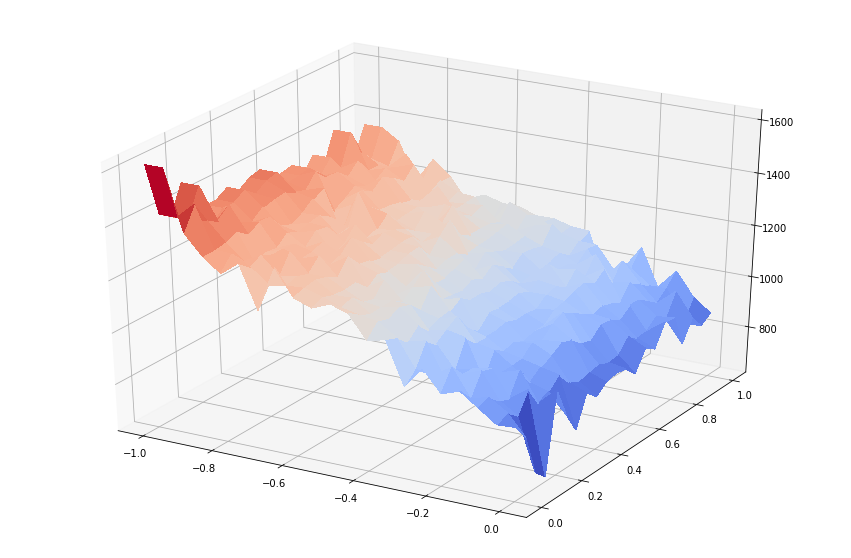

In [154]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

g = int(np.sqrt(df.shape[0]))

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.reshape(df[0].ravel(), (g, g))
y = np.reshape(df[1].ravel(), (g, g))
z = np.reshape(y_1_hat.ravel(), (g, g))

surf = ax.plot_surface(-x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


    
plt.show()

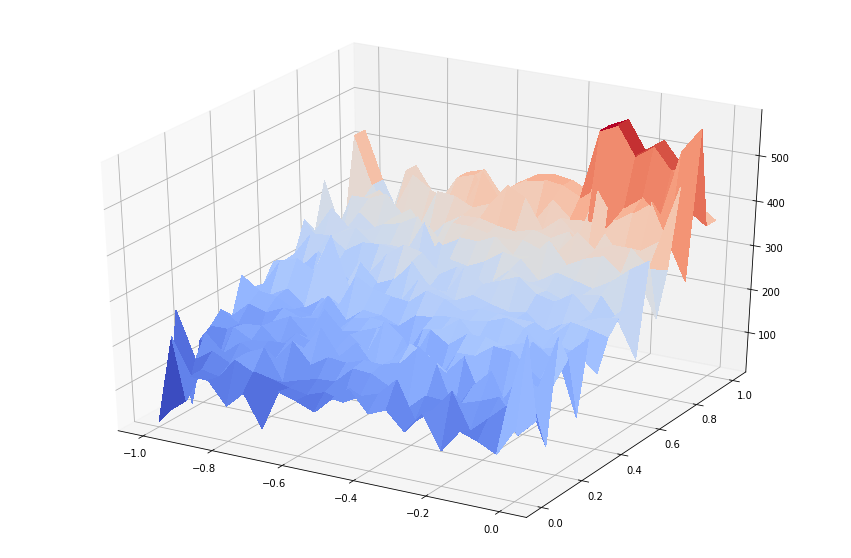

In [155]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

g = int(np.sqrt(df.shape[0]))

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.reshape(df[0].ravel(), (g, g))
y = np.reshape(df[1].ravel(), (g, g))
z = np.reshape(y_2_hat.ravel(), (g, g))

surf = ax.plot_surface(-x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


plt.show()